## Data Modeling
- Model Task is binary Classification
- Data Preprocessing
- Data Augmentation
    - Undersampling
    - SMOTE
- Data Split
    - Stratified 6:2:2
    - K-fold cv
- Modeling
    - Xgboost
    - Random forest
-Evaluation
    - precision, recall
    - marco-f1-score, accuracy
    - AU - PRC

### Data Class 나누기
- Fully Paid : 1497783
- Default(Charged Off + Default) : 362981

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [3]:
data_path = "Dataset/loan_data.csv"
data = pd.read_csv(data_path, low_memory=False)

In [ ]:
"""data_path = "Dataset/Loan_status_2007-2020Q3.gzip"
data = pd.read_csv(data_path, low_memory=False)"""

In [ ]:
"""address = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
data.to_csv(path_or_buf=address+"loan_data.csv", index=False)"""

In [4]:
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [5]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

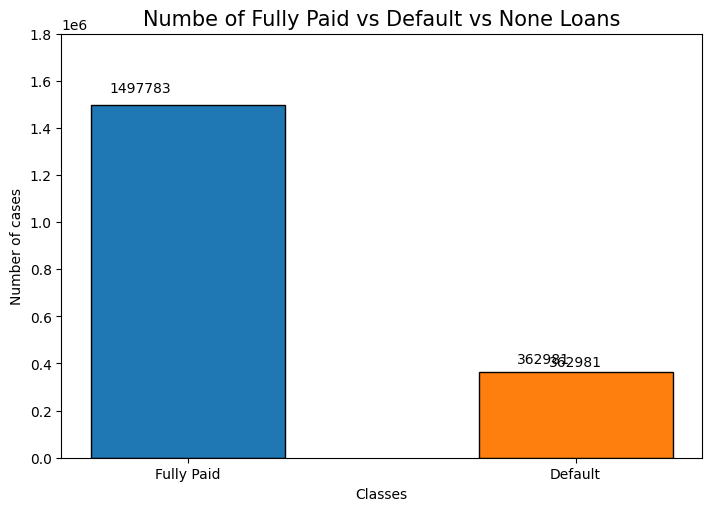

In [6]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)·
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [7]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.126339946167981


### Feature preprocessing
- drop 할 것들 drop
- specific feature 변수 변환

In [8]:
#feature drop
drop_features = ['Unnamed: 0','purpose', 'title','id', 'pymnt_plan', 'policy_code','url']
data = data.drop(columns=drop_features)

In [9]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

print(len(data_x.columns))

134


In [10]:
#data 타입 변환
#퍼센트를 float형태로 바꾸기
def converting_cat_to_num(x):
    if not isinstance(x,str):
        return x  
    return float(x.split("%")[0].lstrip())

#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[0:-2])

def to_data_tranfromer(x):
    if not isinstance(x, str):
        return np.nan
    date = x.split('-')
    if len(date) != 2:
        return np.nan  # 예상치 못한 포맷 처리
    month, year = date[0], date[1]
    return int(year + enum.get(month, "00"))  # "YYYYMM" 형식으로 변환

## 시간 데이터 확인
to_data_features = ["issue_d", "earliest_cr_line", "last_pymnt_d", "next_pymnt_d",\
                    "last_credit_pull_d", "sec_app_earliest_cr_line", "hardship_start_date",\
                   "hardship_end_date", "payment_plan_start_date"]

enum = {'Jan':"01", 'Feb':"02", 'Mar':"03", 
        'Apr':"04", 'May':"05", 'Jun':"06",
        'Jul':"07", 'Aug':"08", 
        'Sep':"09", 'Oct':"10", 
        'Nov':"11", 'Dec':"12"}

# Converting numerically data stored as categorical
data_x['int_rate'] = data_x['int_rate'].map(converting_cat_to_num)
data_x['revol_util'] = data_x['revol_util'].map(converting_cat_to_num)

# Filtering the zip code
data_x["zip_code"] = data_x["zip_code"].map(filter_zip_code)


for name in to_data_features:
    data_x[name] = data_x[name].map(to_data_tranfromer)

print("Successfully converted!")

Successfully converted!


In [11]:
# Analyzing the numerical data generally
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

# Check columns
columns_name_to_check = data_x.columns
#columns_name_to_check = columns_name_to_check.drop("loan_status")
# Calculating
for name in columns_name_to_check:
    number_of_nulls = data_x[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(data_x[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (data_x[name].count() - data_x[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/data_x[name].count()    

# Restructuring the Gathered Information
reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,loan_amnt,0,0.000000,1859196,0.999157
26,revol_bal,0,0.000000,1766468,0.949324
28,total_acc,0,0.000000,1860615,0.999920
29,initial_list_status,0,0.000000,1860762,0.999999
30,out_prncp,0,0.000000,1860331,0.999767
31,out_prncp_inv,0,0.000000,1860331,0.999767
32,total_pymnt,0,0.000000,139308,0.074866
33,total_pymnt_inv,0,0.000000,545866,0.293356
34,total_rec_prncp,0,0.000000,1593522,0.856380
25,pub_rec,0,0.000000,1860722,0.999977


In [12]:
#Missing value ratio가 5를 넘어가는 것들은 모두 drop
features_to_remove = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > 5)]["Attribute Names"])
print(f"List of features that need to be removed: {len(features_to_remove)}")

for  name in features_to_remove:
    data_x.drop(labels=name, axis=1, inplace=True)

print("Non-high presence features have been deleted successfully!")

List of features that need to be removed: 54
Non-high presence features have been deleted successfully!


In [13]:
print(f"The number of features : {len(data_x.columns)}\nThe target feature : {data_y.columns}")

The number of features : 80
The target feature : Index(['loan_status'], dtype='object')


### Handle Missing Value
- Drop 데이터를 어차피 180만개 중에서 10만개만 사라진다.

In [14]:
print(f"Before drop: {data_x.shape[0]} samples")
data_t = pd.concat([data_x, data_y], axis = 1)
data_x_cleaned = data_t.dropna()

data_x = data_x_cleaned.drop(columns='loan_status')
data_y = data_x_cleaned[['loan_status']]

print(f"After drop: {data_x.shape[0]} samples")

Before drop: 1860764 samples
After drop: 1758019 samples


### Label Encoding

In [15]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

Encoded data_x sample:
        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
42536    12000.0      12000.0          12000.0     0     10.99       392.81   
42537     4800.0       4800.0           4800.0     0     10.99       157.13   
42538    27050.0      27050.0          27050.0     0     10.99       885.46   
42539    12000.0      12000.0          12000.0     0      7.62       373.94   
42540    14000.0      14000.0          14000.0     0     12.85       470.71   

       grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
42536      1          6               5     60000.0  ...           100.0   
42537      1          6               1     39600.0  ...           100.0   
42538      1          6               4     55000.0  ...           100.0   
42539      0          2               1     96500.0  ...           100.0   
42540      1          8               5     88000.0  ...            78.6   

       percent_bc_gt_75  pub_rec_bankruptcie

### Augmentation
- Undersampling

In [17]:
data_total = pd.concat([data_x, data_y], axis=1)

In [18]:
# Feature와 Target 분리
X = data_total.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_total[['loan_status']]  # Target (타겟 변수)

# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {X.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=X.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1415249
1               342770
Name: count, dtype: int64
Original data size: 1758019 samples
Undersampled data size: 685540 samples

Undersampling imbalance check
loan_status
0    342770
1    342770
Name: count, dtype: int64


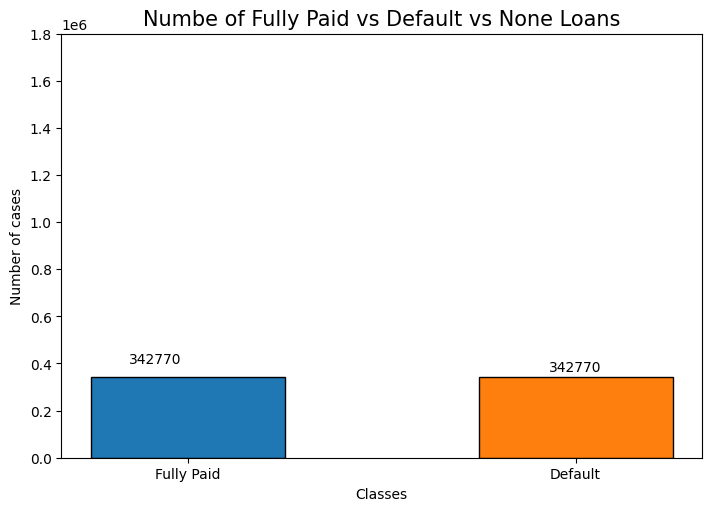

In [19]:
# Visualizing the encoded target

defalut_fully_paid = data_under['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.7,400000,defalut_fully_paid[0])
# ax.text(5.6,1150000,none_)

fig.show()

In [20]:
X = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_under[['loan_status']]  # Target (타겟 변수)

In [21]:
# data under 6:2:2 train,val,test set

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_under):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_under):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_under):.1%})")

Train size: 411324 samples (60.0%)
Validation size: 137108 samples (20.0%)
Test size: 137108 samples (20.0%)


### Min - Max Scaling

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
121862    0.230769     0.230769         0.236155   0.0  0.616822     0.206238   
2698915   0.610897     0.610897         0.613622   0.0  0.289330     0.475784   
1913760   0.282051     0.282051         0.287078   0.0  0.283489     0.220690   
410763    1.000000     1.000000         1.000000   0.0  0.198988     0.750902   
2323012   0.528205     0.528205         0.531509   1.0  0.389408     0.288943   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
121862   0.666667   0.617647             1.0    0.007273  ...           1.000   
2698915  0.333333   0.294118             1.0    0.011364  ...           1.000   
1913760  0.333333   0.323529             0.2    0.002182  ...           1.000   
410763   0.166667   0.205882             0.2    0.034093  ...           1.000   
2323012  0.333333   0.411765             0.2    0.004364  ...           0.943   

   

### Models
- MLP 버전

In [53]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, early_stopping_rounds=10):
    train_losses, val_losses = [], []
    best_val_acc = 0
    best_model = None
    no_improve = 0
    
    for epoch in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}"):
        model.fit(X_train, y_train)

        # Train & Validation Accuracy
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_losses.append(1 - train_acc)  # Loss를 1 - Accuracy로 표현
        val_losses.append(1 - val_acc)

        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= early_stopping_rounds:
            print(f"Early Stopping at epoch {epoch+1}")
            break

    return best_model, train_losses, val_losses, best_val_acc

def plot_loss_curve(train_losses, val_losses, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (1 - Accuracy)')
    plt.title(f"{model_name} Training Loss Curve")
    plt.legend()
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # Precision, Recall, F1-score
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # AU-PRC 계산
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_prc = auc(recall, precision)

    # AU-PRC 곡선 그리기
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.show()
    
    return accuracy_score(y_test, y_pred)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=500,  
        max_depth=15,      
        min_samples_split=4,  
        min_samples_leaf=2,   
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=500,       
        learning_rate=0.1,      
        max_depth=6,          
        subsample=0.9,         
        colsample_bytree=0.9,  
        random_state=42
    )
}

In [ ]:
best_val_accs = {}
best_test_accs = {}

for model_name, model in models.items():
    print(f"\n🚀 Training {model_name}...")
    
    # 모델 학습 (Early Stopping 적용)
    best_model, train_losses, val_losses, best_val_acc = train_model(model, X_train, y_train, X_val, y_val, epochs=300, early_stopping_rounds=10)
    
    # 학습 곡선 시각화
    plot_loss_curve(train_losses, val_losses, model_name)
    
    # 모델 평가 (Precision, Recall, F1-score, AU-PRC)
    test_acc = evaluate_model(best_model, X_test, y_test, model_name)
    
    # 성능 저장
    best_val_accs[model_name] = best_val_acc
    best_test_accs[model_name] = test_acc

print("\n🎯 Best Model Performance Summary:")
for model_name in models.keys():
    print(f"{model_name} - Best Val Accuracy: {best_val_accs[model_name]:.4f}, Test Accuracy: {best_test_accs[model_name]:.4f}")

### Base 
- Augmentation 진행 하지 않은 경우
- model XGBoost

In [27]:
data_orinal = data_total.copy()

In [28]:
# data under 6:2:2 train,val,test set

X = data_orinal.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_orinal[['loan_status']]  # Target (타겟 변수)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_orinal):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_orinal):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_orinal):.1%})")

Train size: 1054811 samples (60.0%)
Validation size: 351604 samples (20.0%)
Test size: 351604 samples (20.0%)


In [29]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
775875    0.346154     0.346154         0.350732   0.0  0.073988     0.257858   
1533535   0.280769     0.280769         0.285805   0.0  0.357477     0.235758   
52610     0.282051     0.282051         0.287078   0.0  0.139798     0.218097   
2392703   0.282051     0.282051         0.287078   0.0  0.123832     0.216765   
121025    0.410256     0.410256         0.414386   0.0  0.139798     0.310825   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
775875   0.000000   0.058824             0.2    0.000864  ...           1.000   
1533535  0.333333   0.382353             1.0    0.000773  ...           0.940   
52610    0.000000   0.117647             0.2    0.000845  ...           1.000   
2392703  0.166667   0.147059             1.0    0.000591  ...           0.882   
121025   0.000000   0.117647             1.0    0.000482  ...           0.950   

   

In [31]:
# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

[0]	validation_0-logloss:0.48852	validation_1-logloss:0.48852
[1]	validation_0-logloss:0.48067	validation_1-logloss:0.48066
[2]	validation_0-logloss:0.47316	validation_1-logloss:0.47316
[3]	validation_0-logloss:0.46575	validation_1-logloss:0.46573
[4]	validation_0-logloss:0.45896	validation_1-logloss:0.45895
[5]	validation_0-logloss:0.45211	validation_1-logloss:0.45210
[6]	validation_0-logloss:0.44547	validation_1-logloss:0.44546
[7]	validation_0-logloss:0.43886	validation_1-logloss:0.43885
[8]	validation_0-logloss:0.43259	validation_1-logloss:0.43258
[9]	validation_0-logloss:0.42633	validation_1-logloss:0.42630
[10]	validation_0-logloss:0.42039	validation_1-logloss:0.42037
[11]	validation_0-logloss:0.41445	validation_1-logloss:0.41442
[12]	validation_0-logloss:0.40866	validation_1-logloss:0.40862
[13]	validation_0-logloss:0.40301	validation_1-logloss:0.40297
[14]	validation_0-logloss:0.39766	validation_1-logloss:0.39761
[15]	validation_0-logloss:0.39230	validation_1-logloss:0.39225
[1

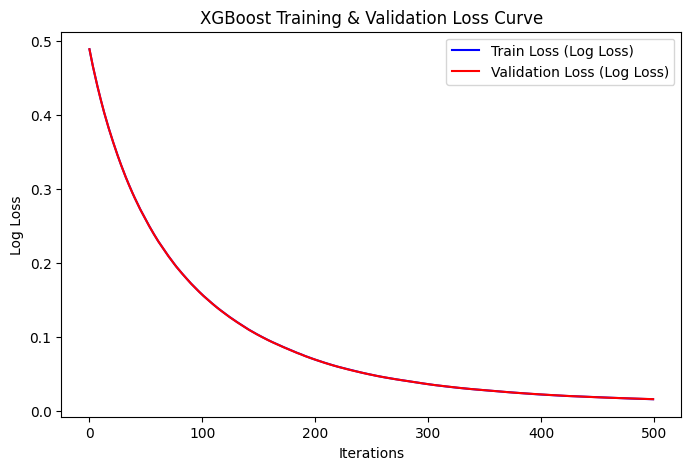

🔹 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    283050
           1       1.00      0.98      0.99     68554

    accuracy                           1.00    351604
   macro avg       1.00      0.99      0.99    351604
weighted avg       1.00      1.00      1.00    351604



In [32]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

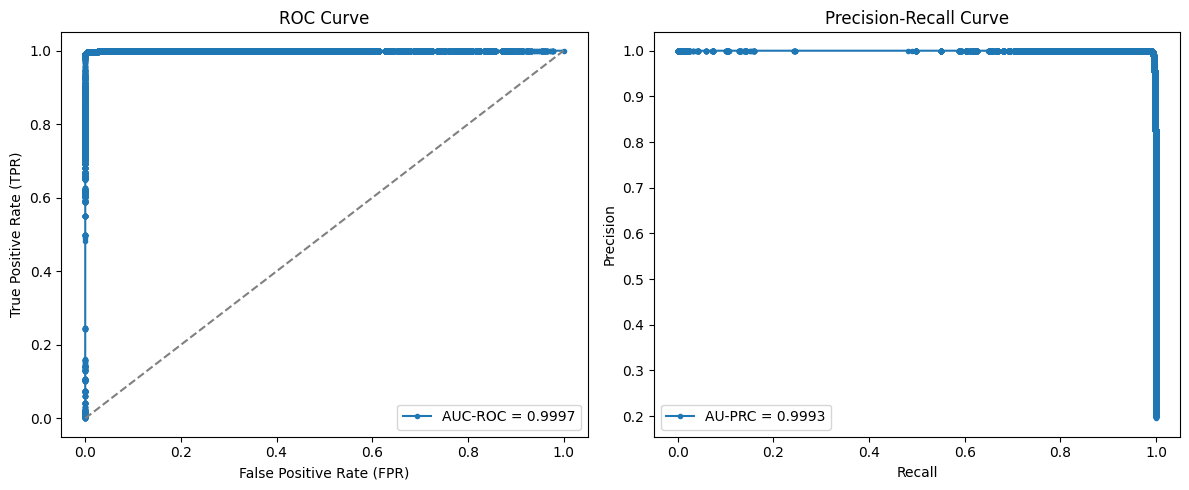

In [33]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

### Undersampling 진행한 경우 
- Model Xgboost

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

[0]	validation_0-logloss:0.68391	validation_1-logloss:0.68392
[1]	validation_0-logloss:0.67492	validation_1-logloss:0.67495
[2]	validation_0-logloss:0.66604	validation_1-logloss:0.66608
[3]	validation_0-logloss:0.65733	validation_1-logloss:0.65739
[4]	validation_0-logloss:0.64909	validation_1-logloss:0.64916
[5]	validation_0-logloss:0.64069	validation_1-logloss:0.64077
[6]	validation_0-logloss:0.63244	validation_1-logloss:0.63253
[7]	validation_0-logloss:0.62436	validation_1-logloss:0.62447
[8]	validation_0-logloss:0.61640	validation_1-logloss:0.61653
[9]	validation_0-logloss:0.60861	validation_1-logloss:0.60874
[10]	validation_0-logloss:0.60103	validation_1-logloss:0.60117
[11]	validation_0-logloss:0.59359	validation_1-logloss:0.59374
[12]	validation_0-logloss:0.58629	validation_1-logloss:0.58645
[13]	validation_0-logloss:0.57910	validation_1-logloss:0.57927
[14]	validation_0-logloss:0.57197	validation_1-logloss:0.57215
[15]	validation_0-logloss:0.56494	validation_1-logloss:0.56513
[1

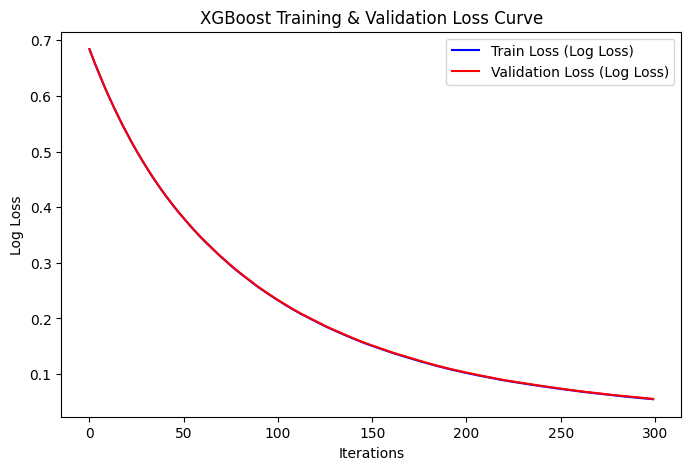

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     68554
           1       1.00      0.99      0.99     68554

    accuracy                           0.99    137108
   macro avg       0.99      0.99      0.99    137108
weighted avg       0.99      0.99      0.99    137108



In [25]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

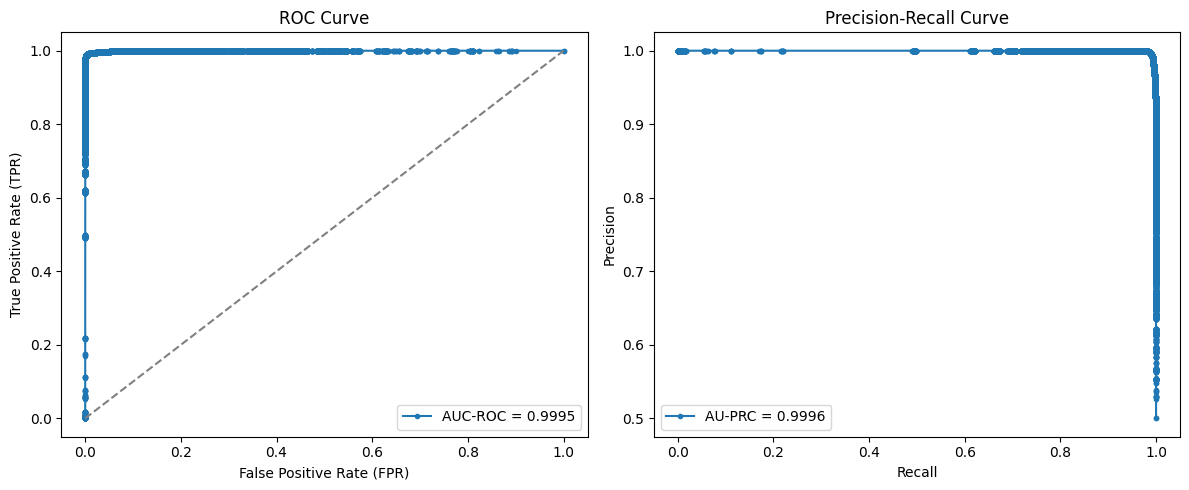

In [26]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

In [ ]:
"""pip list --format=freeze > requirements.txt"""

Note: you may need to restart the kernel to use updated packages.
